**Table of contents**<a id='toc0_'></a>    
- [Zadanie:](#toc1_1_)    
  - [Visualization functions](#toc1_2_)    
  - [Prepare data](#toc1_3_)    
    - [Dataset](#toc1_3_1_)    
    - [Load data](#toc1_3_2_)    
    - [Reshape data](#toc1_3_3_)    
    - [Normalize data](#toc1_3_4_)    
    - [Train - Validate - Test split](#toc1_3_5_)    
    - [Class weights](#toc1_3_6_)    
    - [% of positive cases](#toc1_3_7_)    
  - [Create NN](#toc1_4_)    
  - [Regularization L1 & L2](#toc1_5_)    
  - [Dropout](#toc1_6_)    
  - [Batch normalization](#toc1_7_)    
- [Conclusion](#toc2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Zadanie:](#toc0_)

Proszę spróbować przeprowadzić taki proces regularyzacji modeli dla innego, nietrywialnego zbioru uczącego.

In [20]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)
print('GPU Name : ',tf.config.list_physical_devices('GPU'))

from keras import models
from keras import layers
from keras import regularizers
import seaborn as sns
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
LABELS= ['0', '1']

TensorFlow version: 2.16.1
Keras version: 3.0.5
GPU Name :  []


## <a id='toc1_2_'></a>[Visualization functions](#toc0_)

In [21]:

def visualize_confusion_matrix_for_models(X_test, Y_test, *models) -> None:
    """
    Visualizes the confusion matrices for multiple machine learning models.

    Parameters:
        X_test (array-like): Test data features.
        Y_test (array-like): True labels for the test data.
        *models (variable-length argument list): Machine learning models to evaluate.

    Returns:
        None. Displays confusion matrices using seaborn's heatmap.
    """
    num_models = len(models)
    plt.figure(figsize=(5 * num_models, 5))
    for i, model in enumerate(models, 1):
        plt.subplot(1, num_models, i)
        Y_pred = model.predict(X_test)
        Y_pred = (Y_pred > 0.5)
        matrix = metrics.confusion_matrix(Y_test, Y_pred)
        hm = sns.heatmap(matrix,
                         cmap='coolwarm',
                         linecolor='white',
                         linewidths=1,
                         annot=True,
                         fmt='d')
        plt.yticks(rotation=0)
        hm.set_ylim(0, len(matrix))
        plt.title(f'Confusion Matrix - Model {i}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()


def plot_accuracy_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation accuracy comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation accuracy values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = range(1, len(histories[0].history['acc']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        acc = history.history['acc']
        val_acc = history.history['val_acc']
        plt.plot(epochs, acc, color + 'o', label=f'Training accuracy for {label}')
        plt.plot(epochs, val_acc, color, label=f'Validation accuracy for {label}')

    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



def plot_loss_comparison(*histories, labels: list[str] = None) -> None:
    """
    Plots the training and validation loss comparison for multiple models.

    Args:
    *histories: Variable number of history objects. Each history object should contain
                training and validation loss values.
    labels: List of labels for each model.
    """
    plt.rcParams['figure.figsize'] = (25.0, 5.0)  # set default size of plots
    epochs = range(1, len(histories[0].history['loss']) + 1)  # Assuming all models have the same number of epochs

    for i, history in enumerate(histories):
        color = ['b', 'r', 'g', 'c', 'm', 'y'][i % 6]  # Choose color cyclically
        label = labels[i] if labels else f'Model {i+1}'
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        plt.plot(epochs, loss, color + 'o', label=f'Training loss for {label}')
        plt.plot(epochs, val_loss, color, label=f'Validation loss for {label}')

    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    
def print_val_accuracies(history1, history2, history3):
    val_accuracy1 = history1.history['val_acc']
    val_accuracy2 = history2.history['val_acc']
    val_accuracy3 = history3.history['val_acc']

    argmax1 = np.argmax(val_accuracy1)
    argmax2 = np.argmax(val_accuracy2)
    argmax3 = np.argmax(val_accuracy3)

    print ('Max accuracy for model 1 is: ', val_accuracy1[argmax1], ', achieved in the ', argmax1 , 'epoch.')
    print ('Max accuracy for model 2 is: ', val_accuracy2[argmax2], ', achieved in the ', argmax2 , 'epoch.')
    print ('Max accuracy for model 3 is: ', val_accuracy3[argmax3], ', achieved in the ', argmax3 , 'epoch.')

## <a id='toc1_3_'></a>[Prepare data](#toc0_)

### <a id='toc1_3_1_'></a>[Dataset](#toc0_)
For this excercice I'm going to use Hotel Reservations dataset.
The goal is to predict whether the booking was cancelled or not.
https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset

### <a id='toc1_3_2_'></a>[Load data](#toc0_)

In [22]:
data = pd.read_csv('HotelReservations.csv')
data.drop(['Booking_ID'], axis=1, inplace=True)
print(data.shape)
data.head()

(36275, 18)


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


### <a id='toc1_3_3_'></a>[Reshape data](#toc0_)

In [23]:
data['booking_status'] = data['booking_status'].map({'Canceled': 1, 'Not_Canceled': 0})
data = pd.get_dummies(data, columns=['market_segment_type'], prefix='market_segment')
data = pd.get_dummies(data, columns=['type_of_meal_plan'], prefix='meal_plan')
data['room_type_reserved'] = data['room_type_reserved'].str[-1].astype(int)
data.head()


,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,...,booking_status,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online,meal_plan_Meal Plan 1,meal_plan_Meal Plan 2,meal_plan_Meal Plan 3,meal_plan_Not Selected
0,2,0,1,2,0,1,224,2017,10,2,...,0,False,False,False,True,False,True,False,False,False
1,2,0,2,3,0,1,5,2018,11,6,...,0,False,False,False,False,True,False,False,False,True
2,1,0,2,1,0,1,1,2018,2,28,...,1,False,False,False,False,True,True,False,False,False
3,2,0,0,2,0,1,211,2018,5,20,...,1,False,False,False,False,True,True,False,False,False
4,2,0,1,1,0,1,48,2018,4,11,...,1,False,False,False,False,True,False,False,False,True


### <a id='toc1_3_4_'></a>[Normalize data](#toc0_)

```python
# min-max normalization:
df=(df-df.min())/(df.max()-df.min())
# mean normalization:
df=(df-df.mean())/df.std()
```

In [24]:
data_og = data.copy()

for column_name in data.columns:
    column = data[column_name]
    unique_values = column.unique()
    
    if sorted(unique_values) != [0, 1]:
        column = (column - column.mean()) / column.std()
        
    # change true/false to 1/0
    data[column_name] = column.astype(np.float32)
    
data.head()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,...,booking_status,market_segment_Aviation,market_segment_Complementary,market_segment_Corporate,market_segment_Offline,market_segment_Online,meal_plan_Meal Plan 1,meal_plan_Meal Plan 2,meal_plan_Meal Plan 3,meal_plan_Not Selected
0,0.298889,-0.261467,0.217398,-0.144801,0.0,-0.506404,1.614874,-2.137440,0.839230,-1.555641,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,0.298889,-0.261467,1.365974,0.563964,0.0,-0.506404,-0.933688,0.467837,1.164974,-1.097998,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,-1.628953,-0.261467,1.365974,-0.853566,0.0,-0.506404,-0.980237,0.467837,-1.766723,1.419035,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
3,0.298889,-0.261467,-0.931177,-0.144801,0.0,-0.506404,1.463590,0.467837,-0.789491,0.503751,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
4,0.298889,-0.261467,0.217398,-0.853566,0.0,-0.506404,-0.433285,0.467837,-1.115235,-0.525945,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### <a id='toc1_3_5_'></a>[Train - Validate - Test split](#toc0_)

In [25]:
train_data, test_data, train_labels, test_labels = train_test_split(data.drop(columns = ['booking_status']), data['booking_status'], test_size=0.2, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(test_data, test_labels, test_size=0.5, random_state=42)

### <a id='toc1_3_6_'></a>[Class weights](#toc0_)

In [26]:
def calculate_class_weight(labels):
    count_of_labels = len(labels)
    count_of_positives = labels.sum()
    count_of_negatives = count_of_labels - count_of_positives
    
    positive_weight = count_of_labels /  (2 * count_of_positives)
    negative_weight = count_of_labels / (2 * count_of_negatives)
    
    return {0: negative_weight, 1: positive_weight}

In [27]:
class_weight = calculate_class_weight(data_og['booking_status'])
print(1 / class_weight[0] + 1 / class_weight[1])
print(f"Class weights: {class_weight}")

2.0
Class weights: {0: 0.7436449364493645, 1: 1.5260832982751367}


### <a id='toc1_3_7_'></a>[% of positive cases](#toc0_)

In [28]:
print(f"Positive cases in total: {data_og['booking_status'].sum()}, negative cases in total: {len(data_og['booking_status']) - data_og['booking_status'].sum()}, % of positive cases: {data_og['booking_status'].sum() / len(data_og['booking_status']) * 100:.2f}%")

Positive cases in total: 11885, negative cases in total: 24390, % of positive cases: 32.76%


## <a id='toc1_4_'></a>[Create NN](#toc0_)

In [29]:
def createNNModel(input_shape: int, h1: int = 16, h2: int = 16, h3: int = 16):
    model = models.Sequential(
        [
            layers.Input(shape=(input_shape,)),
            layers.Dense(h1, activation="relu"),
            layers.Dense(h2, activation="relu"),
            layers.Dense(h3, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
    return model

In [30]:
model1 = createNNModel(train_data.shape[1], 16, 16, 16)
model2 = createNNModel(train_data.shape[1], 32, 32, 32)
model3 = createNNModel(train_data.shape[1], 64, 64, 64)
model4 = createNNModel(train_data.shape[1], 128, 96, 64)

model4.summary()

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_84 (Dense)                │ (None, 128)            │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_85 (Dense)                │ (None, 96)             │        12,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 64)             │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,857 (85.38 KB)

 Trainable params: 21,857 (85.38 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
history1 = model1.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history2 = model2.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history3 = model3.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history4 = model4.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)

Epoch 1/150


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - acc: 0.5674 - loss: 0.6745 - val_acc: 0.6998 - val_loss: 0.6305
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7128 - loss: 0.5788 - val_acc: 0.7698 - val_loss: 0.5034
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7721 - loss: 0.4913 - val_acc: 0.7888 - val_loss: 0.4556
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7863 - loss: 0.4627 - val_acc: 0.7869 - val_loss: 0.4464
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7899 - loss: 0.4505 - val_acc: 0.7844 - val_loss: 0.4471
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7902 - loss: 0.4469 - val_acc: 0.7863 - val_loss: 0.4419
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8003 - loss: 0.4388 - val_acc: 0.7943 - val_loss: 0.4271
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.7997 - loss: 0.4352 - val_acc: 0.7943 - val_loss: 0.4265
Epoch 9/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc: 0.8002 - loss: 0.4

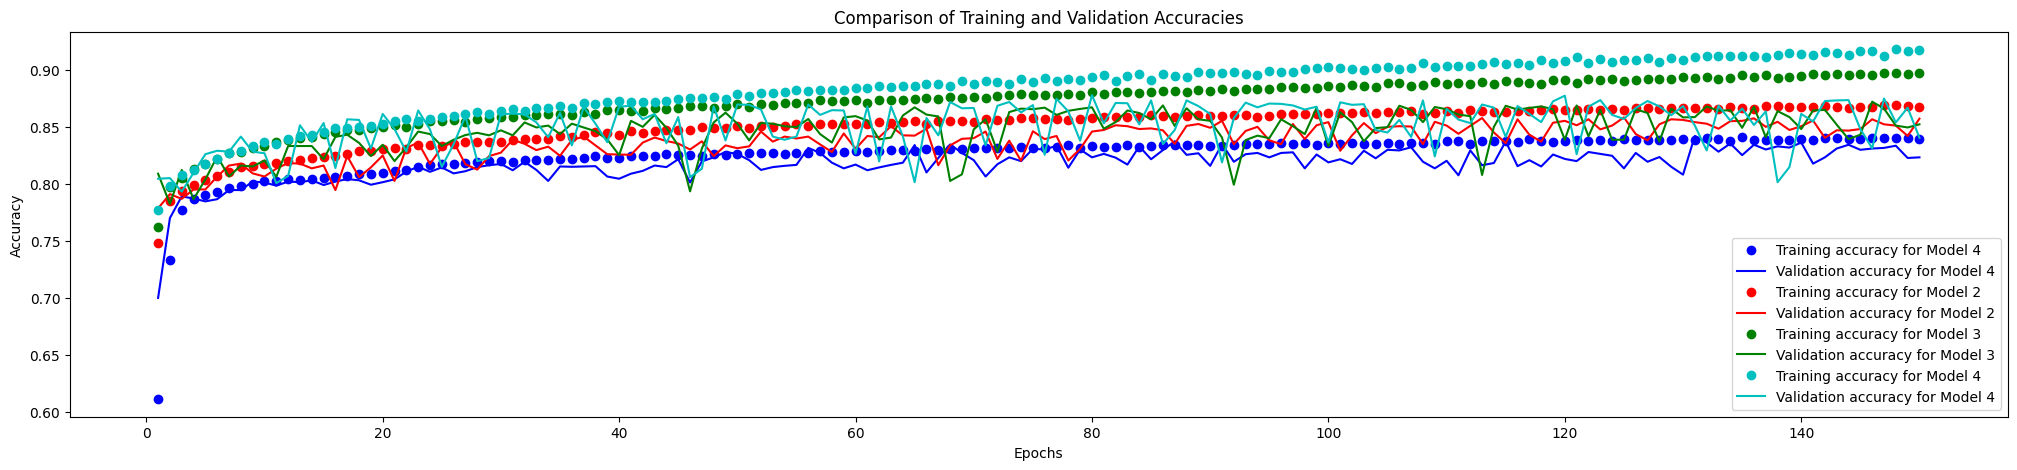

In [32]:
plot_accuracy_comparison(history1, history2, history3, history4, labels=['Model 4', 'Model 2', 'Model 3', 'Model 4'])

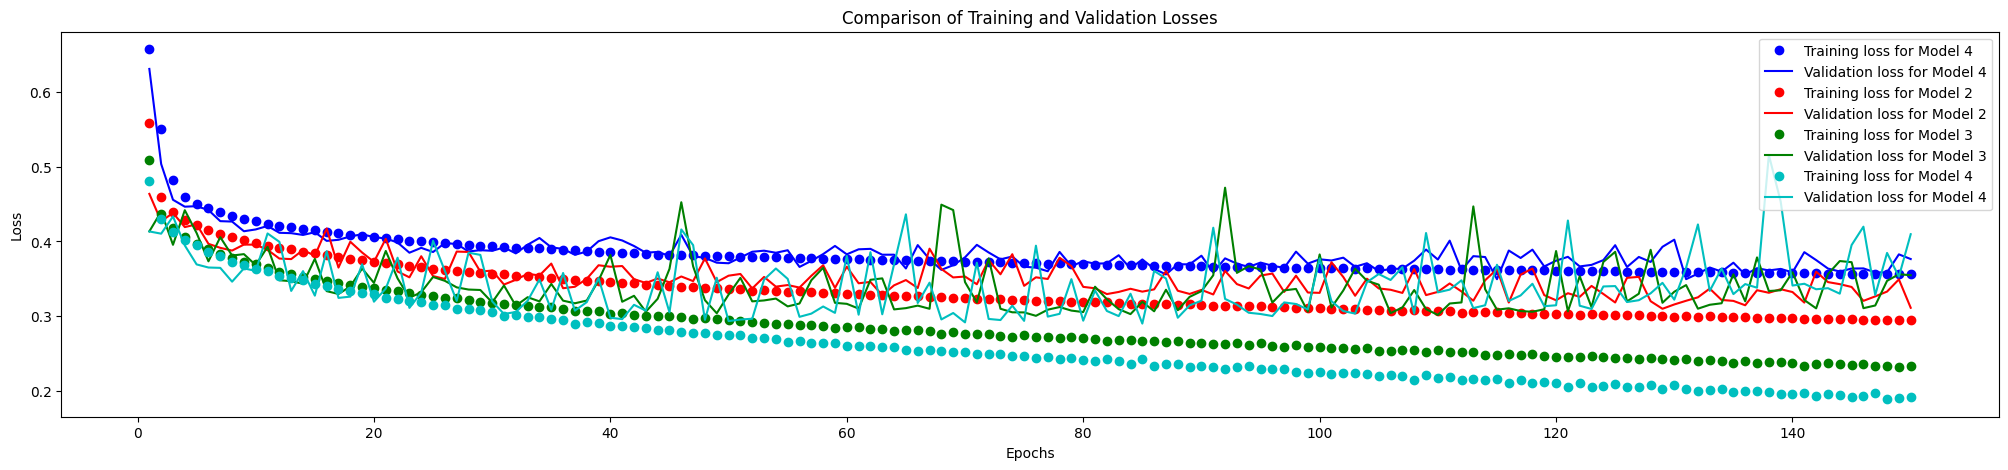

In [33]:
plot_loss_comparison(history1, history2, history3, history4, labels=['Model 4', 'Model 2', 'Model 3', 'Model 4'])

  1/114 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


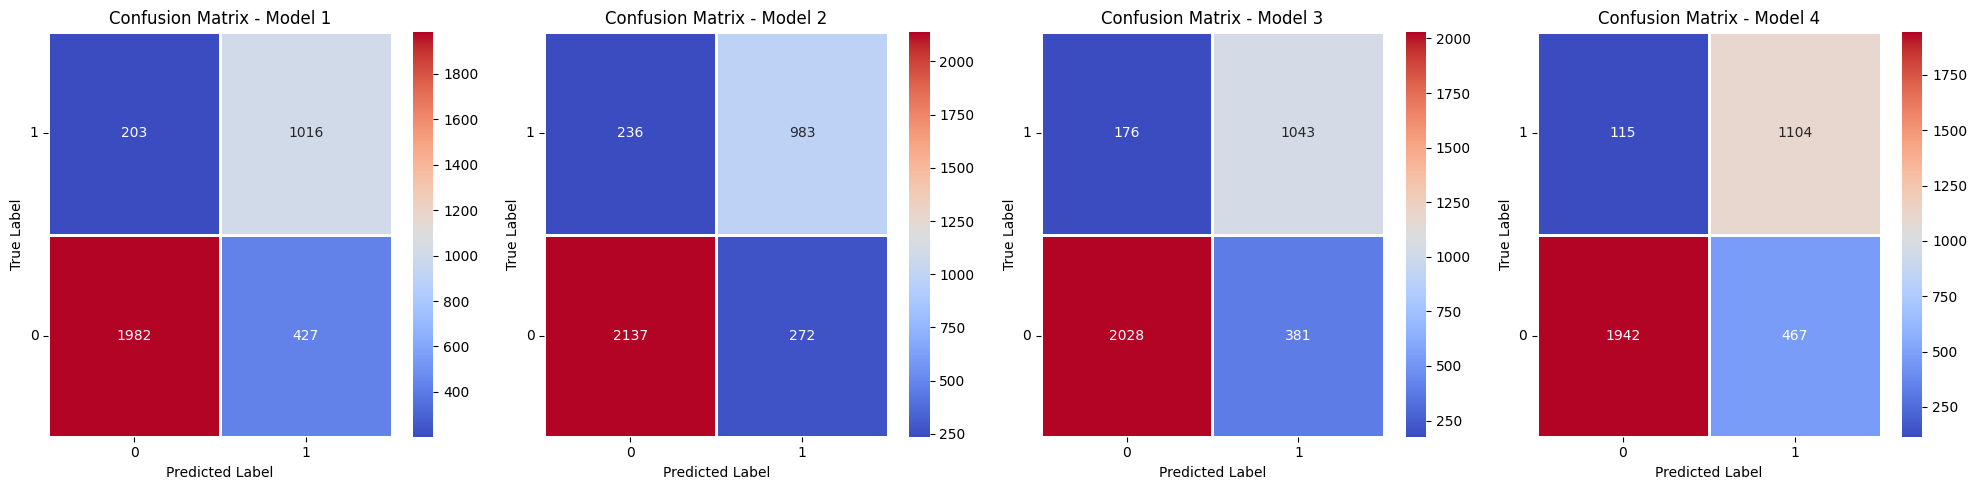

In [34]:
visualize_confusion_matrix_for_models(test_data, test_labels, model1, model2, model3, model4)

Model4 network stands out as best scoring, however it distinctly overfits the training data. It is also the most complex model, with 3 hidden layers and 128 neurons in each of them.  
I chose to use it as a base for further regularization techniques.

## <a id='toc1_5_'></a>[Regularization L1 & L2](#toc0_)

In [35]:
def createNNModelWithRegularizer(input_shape: int, h1: int = 16, h2: int = 16, h3: int = 16, kernel_regularizer=None):
    model = models.Sequential(
        [
            layers.Input(shape=(input_shape,)),
            layers.Dense(h1, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.Dense(h2, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.Dense(h3, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["acc"])
    return model

In [36]:
model_h1 = createNNModelWithRegularizer(train_data.shape[1], 128, 96, 64, regularizers.l1(0.0001))
model_h2 = createNNModelWithRegularizer(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001))
model_h1_h2 = createNNModelWithRegularizer(train_data.shape[1], 128, 96, 64, regularizers.l1_l2(l1=0.0001, l2=0.0001))

history_h1 = model_h1.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_h2 = model_h2.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_h1_h2 = model_h1_h2.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)


Epoch 1/150


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.7258 - loss: 0.7303 - val_acc: 0.7894 - val_loss: 0.6109
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7969 - loss: 0.6032 - val_acc: 0.8230 - val_loss: 0.5470
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8097 - loss: 0.5764 - val_acc: 0.7949 - val_loss: 0.5768
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8127 - loss: 0.5524 - val_acc: 0.8282 - val_loss: 0.5092
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8203 - loss: 0.5292 - val_acc: 0.8004 - val_loss: 0.5425
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8187 - loss: 0.5245 - val_acc: 0.8164 - val_loss: 0.5033
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8263 - loss: 0.5055 - val_acc: 0.8263 - val_loss: 0.4847
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8269 - loss: 0.4951 - val_acc: 0.8406 - val_loss: 0.4613
Epoch 9/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8260 - loss: 0.4

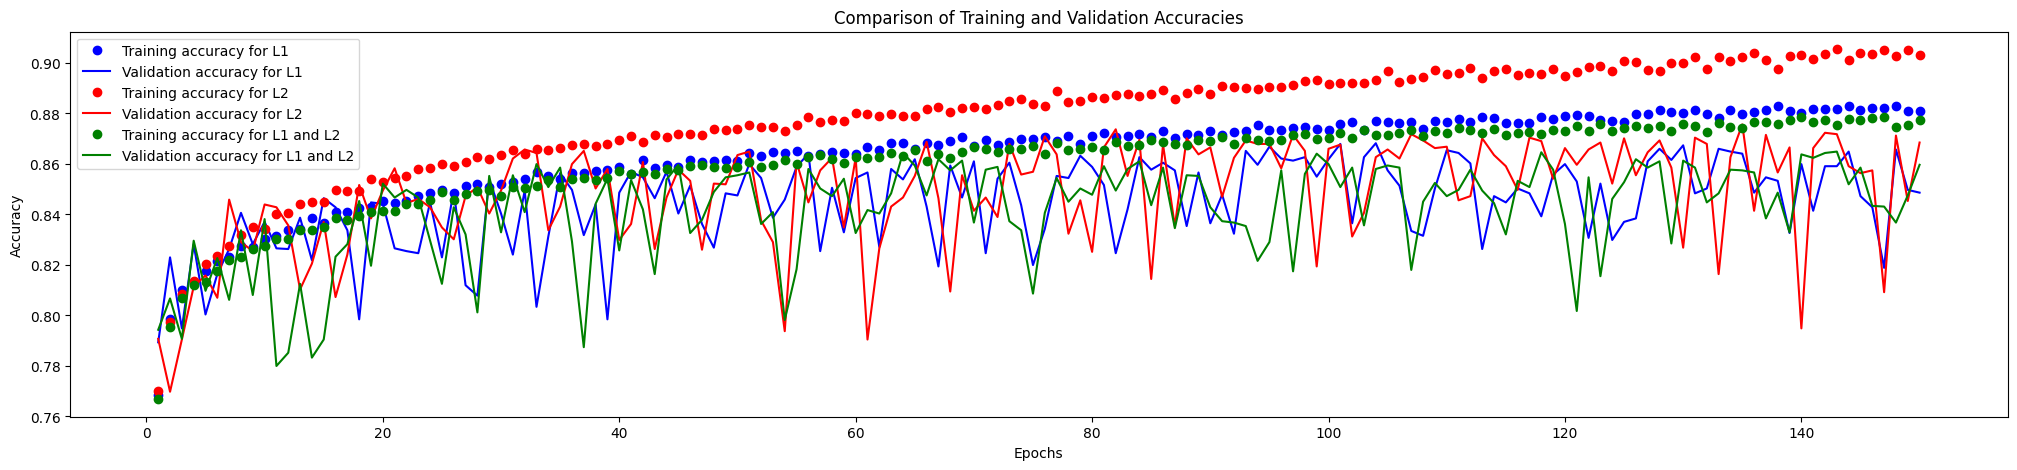

In [37]:
plot_accuracy_comparison(history_h1, history_h2, history_h1_h2, labels=['L1', 'L2', 'L1 and L2'])

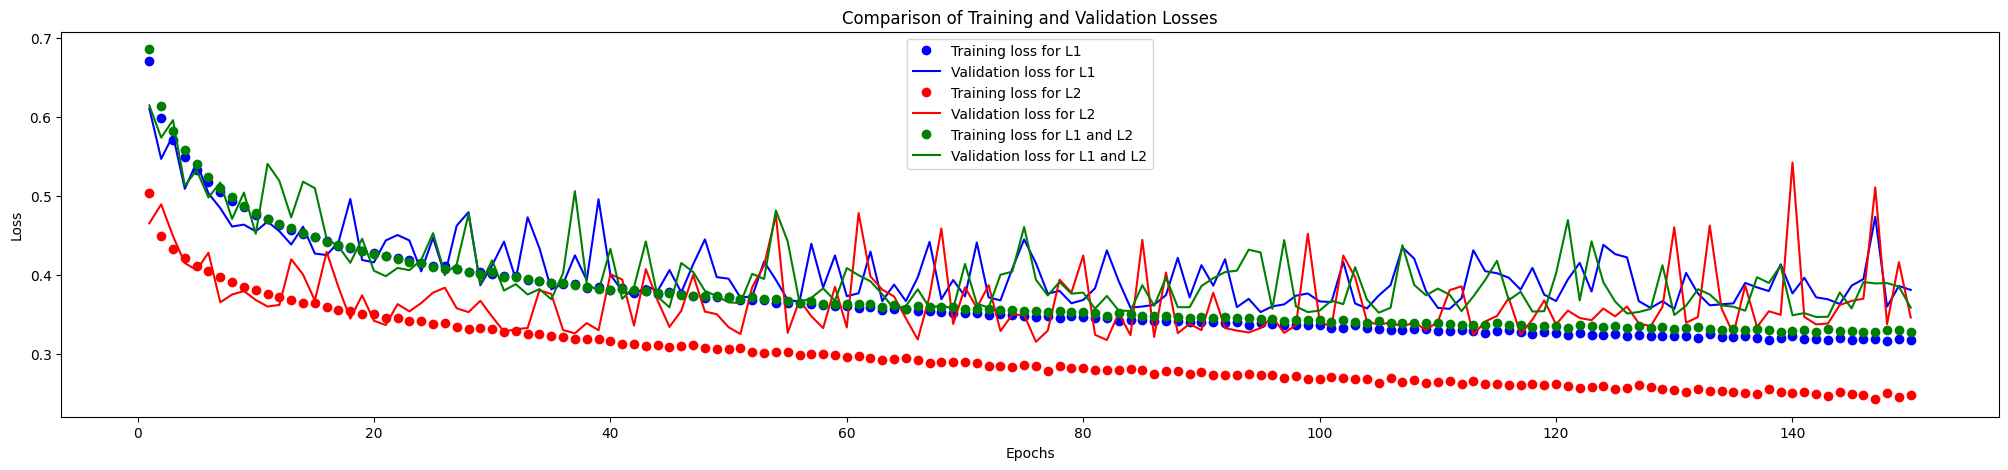

In [38]:
plot_loss_comparison(history_h1, history_h2, history_h1_h2, labels=['L1', 'L2', 'L1 and L2'])

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


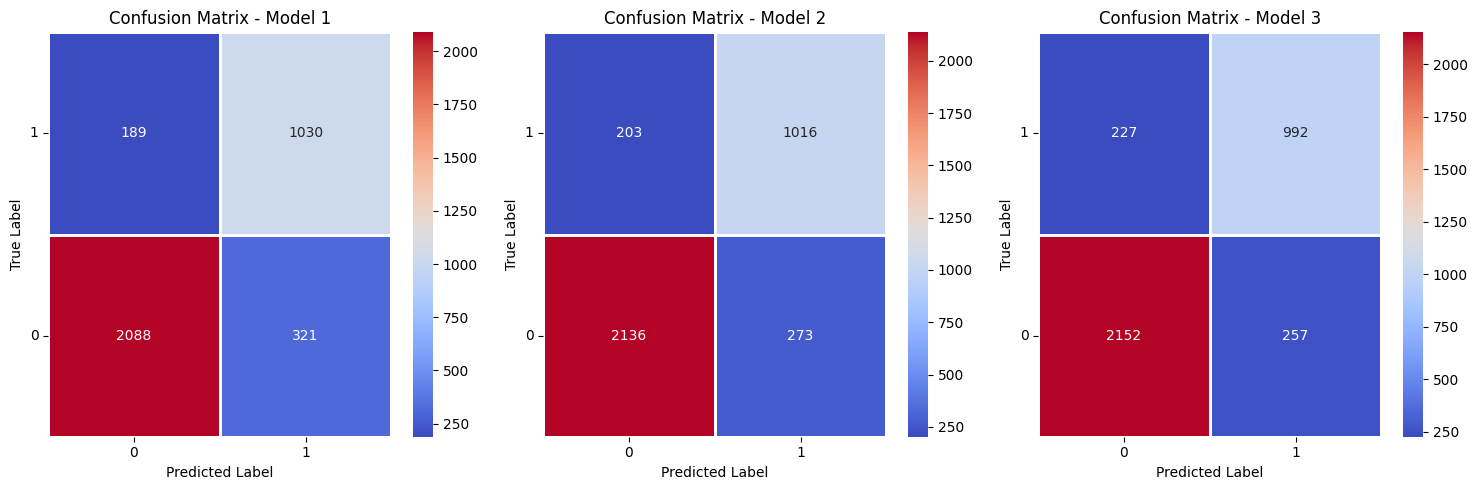

In [39]:
visualize_confusion_matrix_for_models(test_data, test_labels, model_h1, model_h2, model_h1_h2)

All NNs performed similarly, with L2 regularization standing out as most prone to overfitting. This being said, in order to showcase other regularization techniques, I chose to use L2 regularization for further analysis.

## <a id='toc1_6_'></a>[Dropout](#toc0_)

In [40]:
def createNNModelWithDropout(input_shape: int, h1: int = 16, h2: int = 16, h3: int = 16, kernel_regularizer=None, dropout_rate: float = 0.5):
    model = models.Sequential(
        [
            layers.Input(shape=(input_shape,)),
            layers.Dense(h1, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(h2, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(h3, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    return model

In [41]:
model_dropout_1 = createNNModelWithDropout(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0)
model_dropout_2 = createNNModelWithDropout(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.1)
model_dropout_3 = createNNModelWithDropout(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.3)
model_dropout_4 = createNNModelWithDropout(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.5)

In [42]:
history_dropout_1 = model_dropout_1.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_dropout_2 = model_dropout_2.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_dropout_3 = model_dropout_3.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_dropout_4 = model_dropout_4.fit(train_data, train_labels, epochs=150, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)

Epoch 1/150


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - acc: 0.7278 - loss: 0.5600 - val_acc: 0.8098 - val_loss: 0.4315
Epoch 2/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.7976 - loss: 0.4550 - val_acc: 0.7896 - val_loss: 0.4595
Epoch 3/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8015 - loss: 0.4386 - val_acc: 0.8235 - val_loss: 0.3955
Epoch 4/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8140 - loss: 0.4226 - val_acc: 0.8053 - val_loss: 0.4329
Epoch 5/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8130 - loss: 0.4213 - val_acc: 0.8368 - val_loss: 0.3765
Epoch 6/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8242 - loss: 0.4059 - val_acc: 0.8315 - val_loss: 0.3846
Epoch 7/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8281 - loss: 0.3999 - val_acc: 0.8202 - val_loss: 0.3935
Epoch 8/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8258 - loss: 0.3957 - val_acc: 0.8379 - val_loss: 0.3740
Epoch 9/150
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - acc: 0.8373 - loss: 0.3

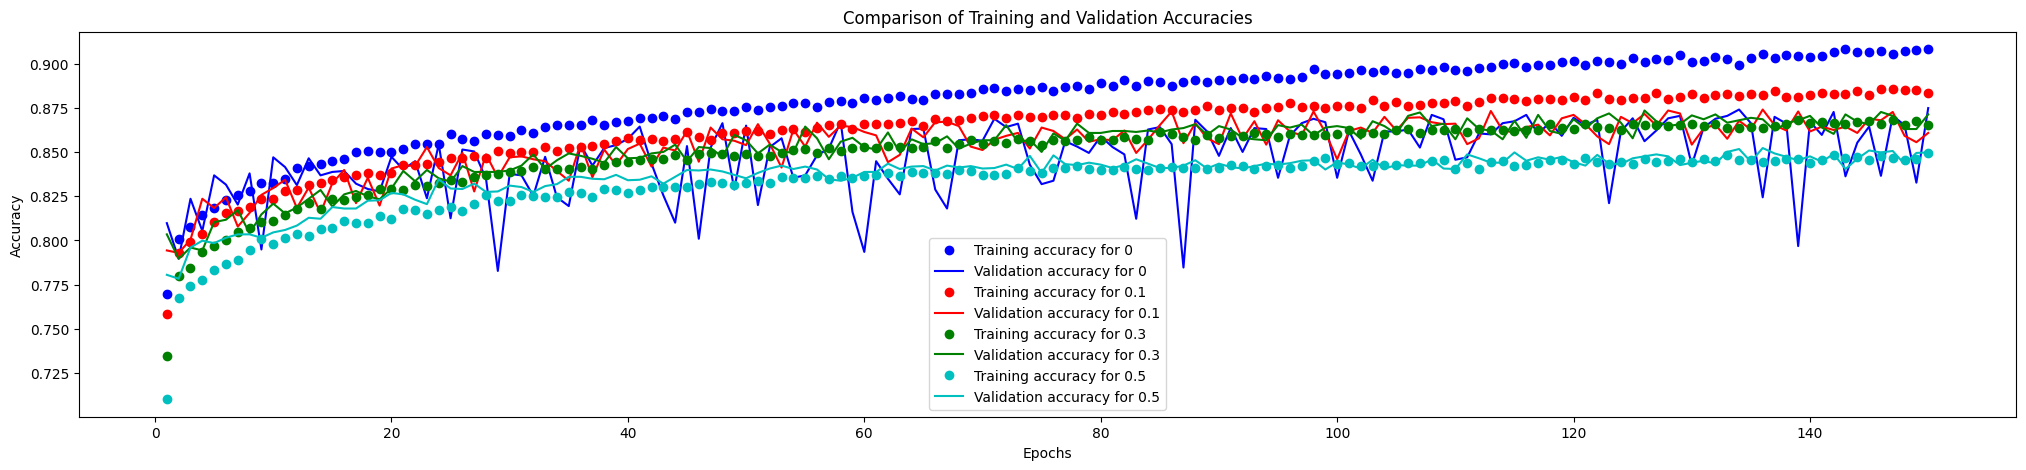

In [43]:
plot_accuracy_comparison(history_dropout_1, history_dropout_2, history_dropout_3, history_dropout_4, labels=['0', '0.1', '0.3', '0.5'])

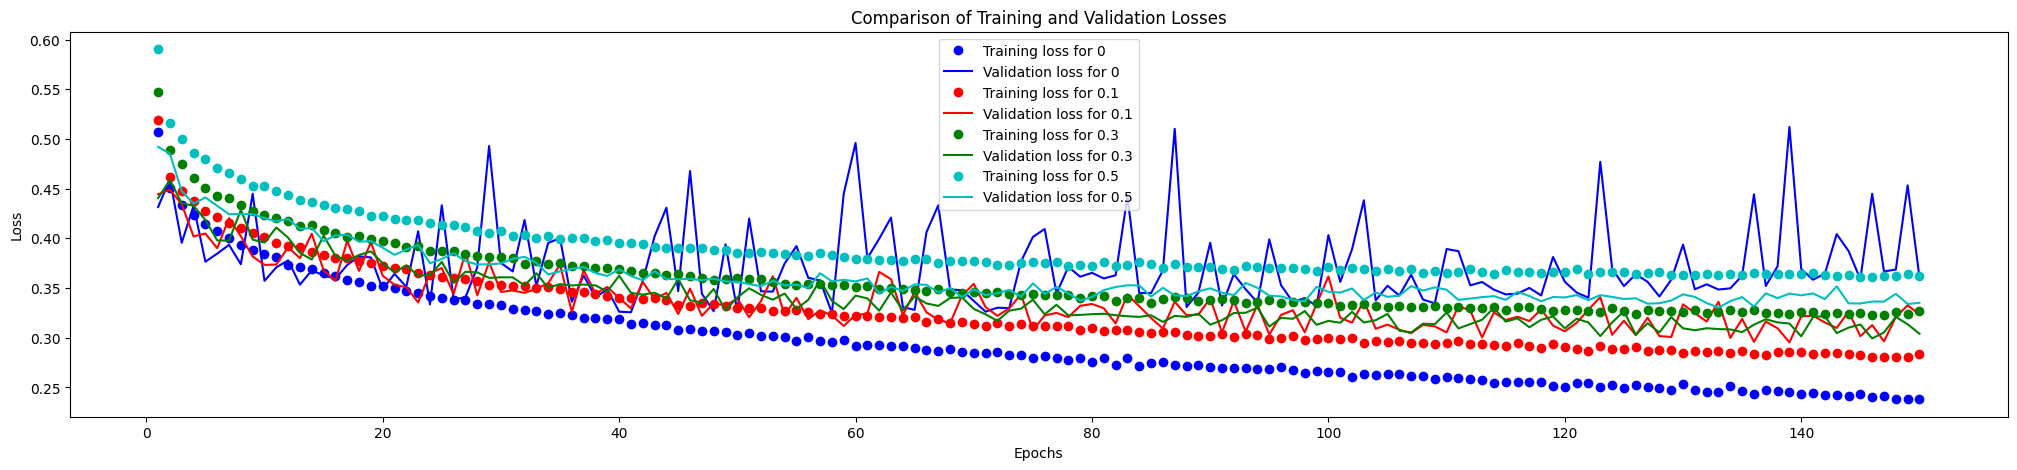

In [44]:
plot_loss_comparison(history_dropout_1, history_dropout_2, history_dropout_3, history_dropout_4, labels=['0', '0.1', '0.3', '0.5'])

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


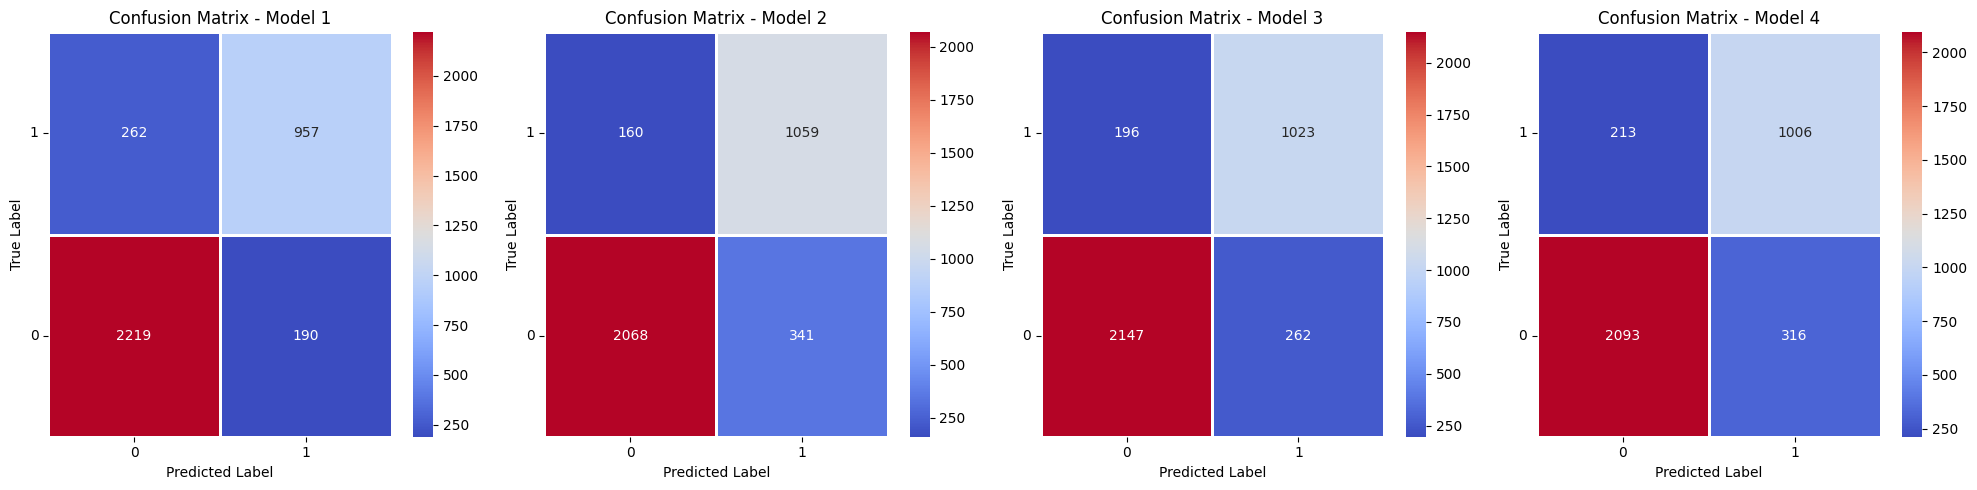

In [45]:
visualize_confusion_matrix_for_models(test_data, test_labels, model_dropout_1, model_dropout_2, model_dropout_3, model_dropout_4)

Dropout performs as one might predict. It agressively lowers overfitting, but we need to be careful with dropout rate value. Too high dropout rate will most certainly hurt learning process.

## <a id='toc1_7_'></a>[Batch normalization](#toc0_)

In [46]:
def createNNModelBatchNormalization(input_shape: int, h1: int = 16, h2: int = 16, h3: int = 16, kernel_regularizer=None, dropout_rate: float = 0.5, double_batch_normalization: bool = False):
    model1 = models.Sequential(
        [
            layers.Input(shape=(input_shape,)),
            layers.Dense(h1, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate),
            layers.Dense(h2, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.Dropout(dropout_rate),
            layers.Dense(h3, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    model2 = models.Sequential(
        [
            layers.Input(shape=(input_shape,)),
            layers.Dense(h1, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate),
            layers.Dense(h2, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.BatchNormalization(),
            layers.Dropout(dropout_rate),
            layers.Dense(h3, kernel_regularizer=kernel_regularizer, activation="relu"),
            layers.Dense(1, activation="sigmoid"),
        ]
    )
    model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    
    return model2 if double_batch_normalization else model1 

In [47]:
model_batch_normalization_1 = createNNModelBatchNormalization(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.3, False)
model_batch_normalization_2 = createNNModelBatchNormalization(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.3, True)
model_batch_normalization_3 = createNNModelBatchNormalization(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.5, False)
model_batch_normalization_4 = createNNModelBatchNormalization(train_data.shape[1], 128, 96, 64, regularizers.l2(0.0001), 0.5, True)
model_batch_normalization_5 = createNNModelBatchNormalization(train_data.shape[1], 256, 128, 96, regularizers.l2(0.0001), 0.5, True)

history_batch_normalization_1 = model_batch_normalization_1.fit(train_data, train_labels, epochs=300, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_batch_normalization_2 = model_batch_normalization_2.fit(train_data, train_labels, epochs=300, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_batch_normalization_3 = model_batch_normalization_3.fit(train_data, train_labels, epochs=300, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_batch_normalization_4 = model_batch_normalization_4.fit(train_data, train_labels, epochs=300, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)
history_batch_normalization_5 = model_batch_normalization_5.fit(train_data, train_labels, epochs=600, batch_size=512, validation_data=(val_data, val_labels), class_weight=class_weight)

Epoch 1/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - acc: 0.6933 - loss: 0.6063 - val_acc: 0.8092 - val_loss: 0.5490
Epoch 2/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7775 - loss: 0.4887 - val_acc: 0.8180 - val_loss: 0.5066
Epoch 3/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7854 - loss: 0.4722 - val_acc: 0.8180 - val_loss: 0.4746
Epoch 4/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7938 - loss: 0.4564 - val_acc: 0.8095 - val_loss: 0.4586
Epoch 5/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7985 - loss: 0.4500 - val_acc: 0.8258 - val_loss: 0.4200
Epoch 6/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8030 - loss: 0.4409 - val_acc: 0.8213 - val_loss: 0.4158
Epoch 7/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8067 - loss: 0.4354 - val_acc: 0.8285 - val_loss: 0.3991
Epoch 8/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8044 - loss: 0.4345 - val_acc: 0.8252 - val_loss: 0.4035
Epoch 9/300
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.8110

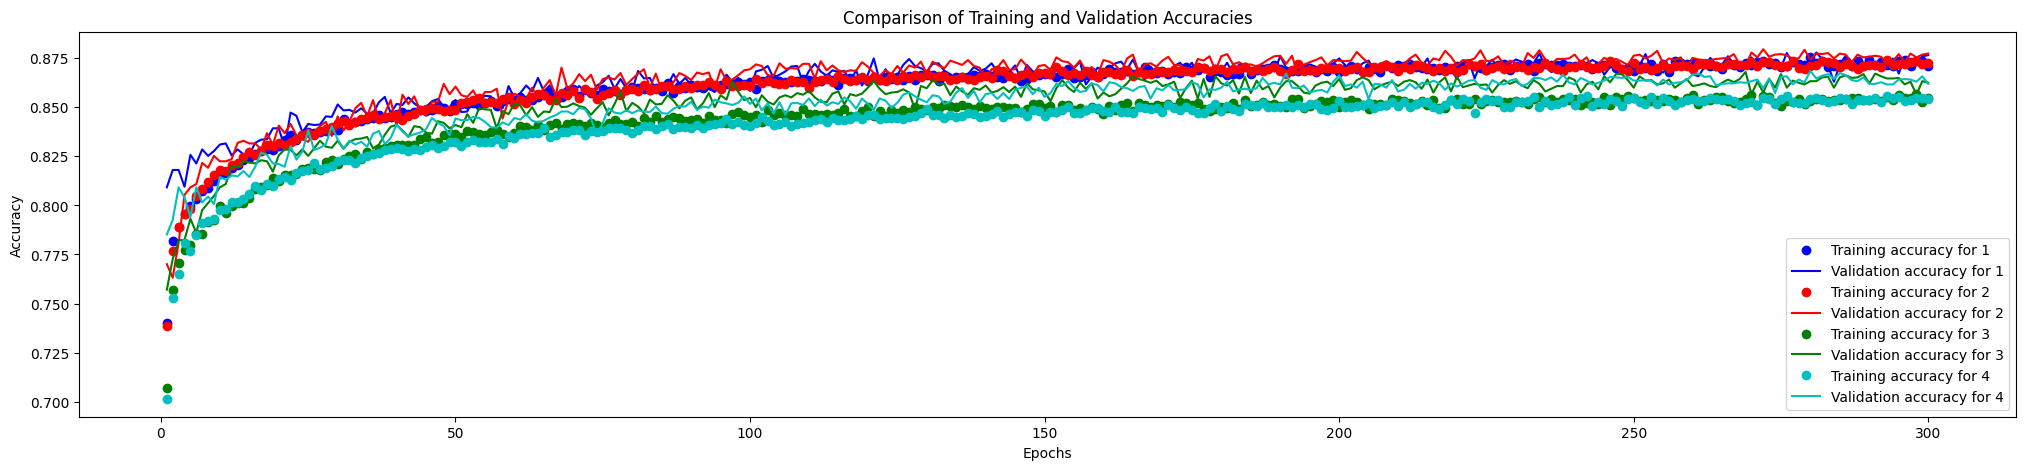

In [48]:
plot_accuracy_comparison(history_batch_normalization_1, history_batch_normalization_2, history_batch_normalization_3, history_batch_normalization_4, labels=['1', '2', '3', '4'])

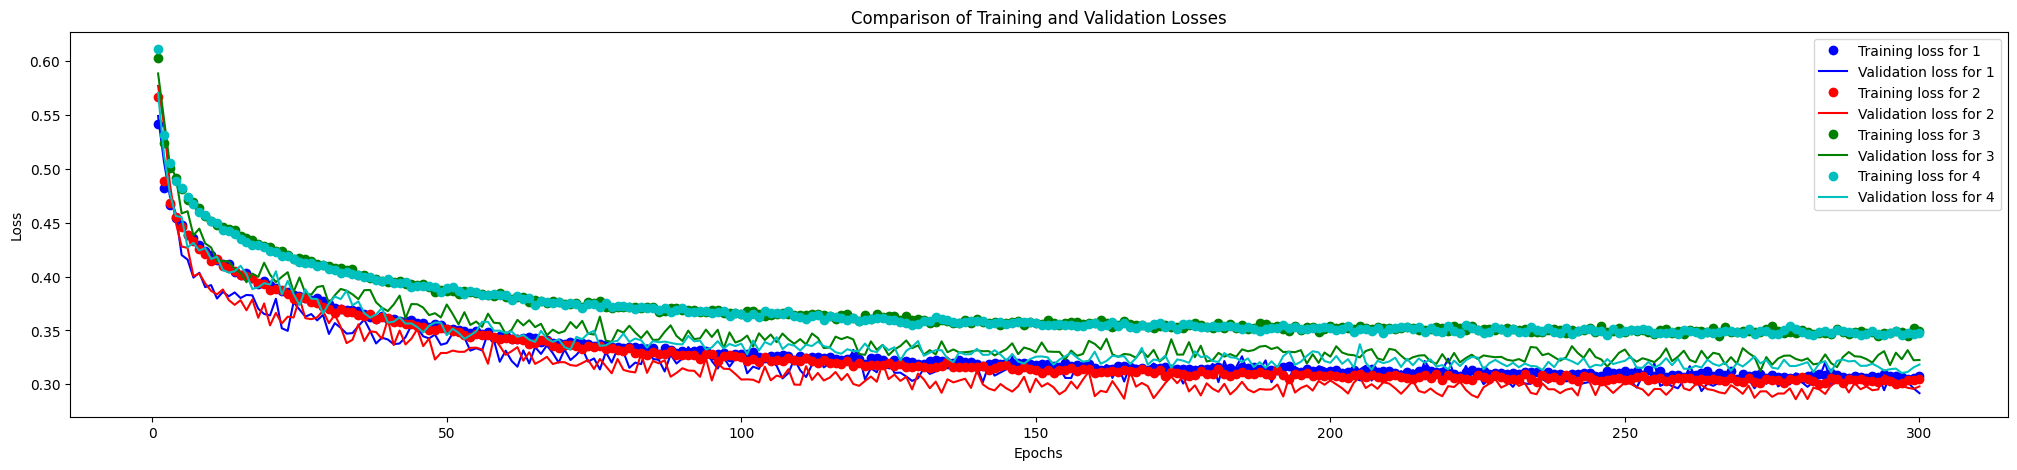

In [49]:
plot_loss_comparison(history_batch_normalization_1, history_batch_normalization_2, history_batch_normalization_3, history_batch_normalization_4, labels=['1', '2', '3', '4'])

114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


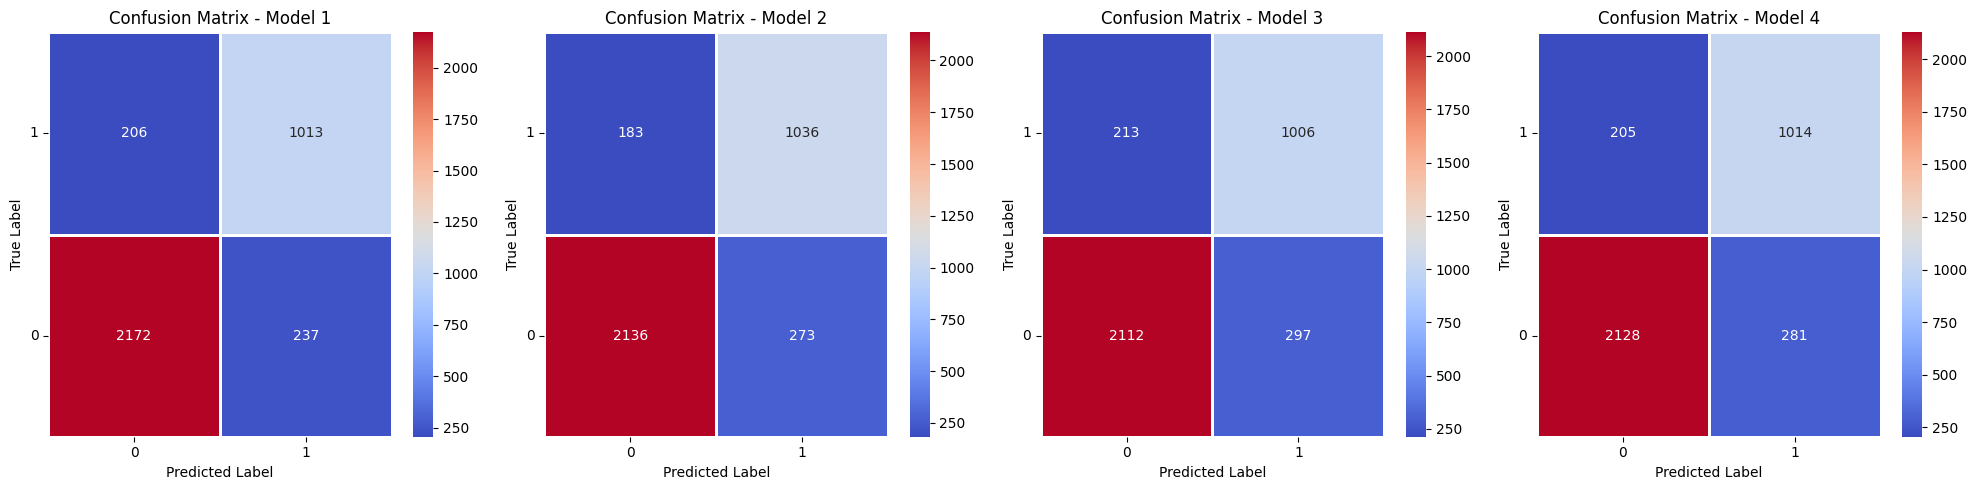

In [50]:
visualize_confusion_matrix_for_models(test_data, test_labels, model_batch_normalization_1, model_batch_normalization_2, model_batch_normalization_3, model_batch_normalization_4)

Batch Normalization proved to be remarkably efficient with this dataset. It significantly lowered overfitting, and improved validation accuracy. 

# <a id='toc2_'></a>[Conclusion](#toc0_)

Things I've learned:
- how does L1 & L2 regularization work
- how does dropout work
- how does batch normalization work
- regularization techniques are not mutually exclusive, they can be used together to achieve better results